# CS446/519 - Class Session 6 - Degree Distribution

In this class session we are going to plot the degree distribution of the undirected human
protein-protein interaction network (PPI), without using `igraph`. We'll obtain the interaction data from the Pathway Commons SIF file (in the `shared/` folder) and we'll 
manually compute the degree of each vertex (protein) in the network. We'll then compute
the count `N(k)` of vertices that have a given vertex degree `k`, for all `k` values.
Finally, we'll plot the degree distribution and discuss whether it is consistent with the 
results obtained in the Jeong et al. article for the yeast PPI.

Let $p_k$ be the fraction of vertices in $G$ that have degree $k$, i.e. in $G$ there would be $p_k \times n$ vertices with degree $k$.

Degree sequence $\lbrace k_1, \dots, k_n \rbrace$

## New Assignment: calculate degree distribution of the human PPI

0. Make a hypothesis: do you think the human PPI will be "scale free"?
1. Select only the `interacts-with` and `in-complex-with` rows of `shared/pathway_commons.sif`
2. Eliminate redundant interactions from the dataset
    - these would all be redundant, for this purpose:
        - A interacts-with B
        - B interacts-with A
        - A in-complex-with B
3. Count how many times each protein symbol appears in any interaction 
    - it is OK if an interaction like this gets counted twice:
        - A interacts-with A
that is basically computing the vertex degree k for each protein
4. Obtain a histogram of counts of $k$ values in about 30 equally spaced bins from 1 to the maximum $k$ value
5. Call the $k$ value at the center of each bin, $k_{bin}$, and the count of proteins whose $k$ values are in that
bin, $N(k_{bin})$.
6. Plot the relationship between $N(k_{bin})$ and $k_{bin}$, on a log-log scatter plot.
7. Do a linear regression to the points on the plot in the "linear range" for small $k_{bin}$, which should be the first five points or so. The negative of the slope gives you the "scaling exponent" gamma.
8. Compare the gamma that you got for the human PPI to the gamma for the yeast PPI.


In [1]:
import pandas
import collections
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

Step 1:  load in the SIF file

In [2]:
sif_data = pandas.read_csv("shared/pathway_commons.sif",
                            sep="\t", names=["species1", "interaction_type", "species2"])

Step 2:  restrict the interactions to protein-protein undirected ("in-complex-with", "interacts-with")

In [3]:
interaction_types_ppi = set(["interacts-with",
                             "in-complex-with"])
interac_ppi = sif_data[sif_data.interaction_type.isin(interaction_types_ppi)]

Step 3: for each interaction, reorder `species1` and `species2` (if necessary) so that
`species1 < species2` (in terms of the species names, in lexicographic order)

In [4]:
for i in range(0, interac_ppi.shape[0]):
    if interac_ppi.iat[i,0] > interac_ppi.iat[i,2]:
        temp_name = interac_ppi.iat[i,0]
        interac_ppi.set_value(i, 'species1', interac_ppi.iat[i,2])
        interac_ppi.set_value(i, 'species2', temp_name)

Step 4: get only the unique interaction pairs of proteins (ignoring the interaction type)

In [5]:
interac_ppi_unique = interac_ppi[["species1","species2"]].drop_duplicates()

Step 5: compute the degree of each vertex (though we will not associate the vertex degrees with vertex names here, since for this exercise we only need the vector of vertex degree values, not the associated vertex IDs)

In [6]:
vertex_degrees_ctr = collections.Counter()
allproteins = interac_ppi_unique["species1"].tolist() + interac_ppi_unique["species2"].tolist()
for proteinname in allproteins:
    vertex_degrees_ctr.update([proteinname])
vertex_degrees = list(vertex_degrees_ctr.values())

Step 6: Calculate the histogram of N(k) vs. k, "suggesting" 30 bin "breaks" (i.e., bin edges) to R; `hist` will actually pick a different number of bins based on its own histogramming algorithm, so we'll find out exactly how many bin breaks that `hist` picked and then we'll call it `nbreaks_actual`, and we'll work with that. 

- `breaks`: the cutoff points for the bins. 你记忆成 "breakpoints" 就好了
    - 所以 $n+1$ 个 breaks 确定 $n$ 个 bins
    - 注意 R 里 `hist(breaks=20)` 表示自行根据数据定 20 个 breaks，也就是 19 个 bins
    - `hist(breaks=c(17,20,23,26,29))` 这样写才是自己指定具体的 break 值
- `counts`: count of examples in each bin. 也就是每个 bin 的高度

In [7]:
nbins=30
hist_res = plt.hist(np.array(vertex_degrees), bins=nbins)
hist_counts = hist_res[0]
hist_breaks = hist_res[1]
hist_breaks_np = np.array(hist_breaks)
# 取每一对 breaks 的中间值
kvals = 0.5*(hist_breaks_np[0:(nbins-1)]+hist_breaks_np[1:nbins])

Step 7: Plot `N(k)` vs. `k`, on log-log scale (using only the first 14 points, which is plenty sufficient to see the approximatey scale-free degree distribution and where it becomes exponentially suppressed at high `k`.

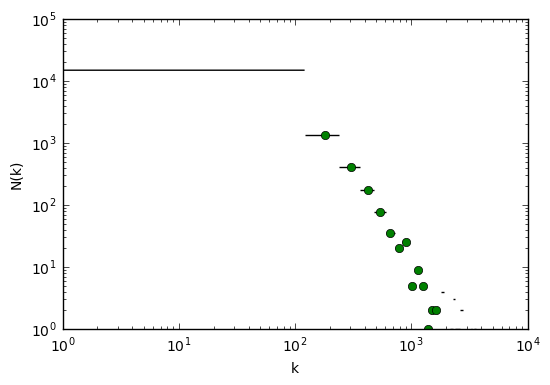

In [8]:
plt.loglog(kvals[1:14],
           hist_counts[1:14], "o")
plt.xlabel("k")
plt.ylabel("N(k)")
plt.show()

Step 8:  Do a linear fit to the log10(N(k)) vs. log10(k) data (just over the range in which the relationship appears to be linear, which is the first five poitns)

In [9]:
scipy.stats.linregress(np.log10(kvals[0:4]), np.log10(hist_counts[0:4]))

LinregressResult(slope=-2.2944987277792217, intercept=8.2831047942938802, rvalue=-0.99958387470184684, pvalue=0.00041612529815315819, stderr=0.046820436096395121)

Slope is -2.3 with SE 0.05, i.e., gamma = 2.3 with a 95% CI of about +/- 0.1.

Now let's compute the slope for the degree distribution Fig. 1b in the Jeong et al. article, for the yeast PPI.  The change in ordinate over the linear range is about -6.5 in units of natural logarithm. The change in abscissa over the linear range is approximately log(45)-log(2), so we can compute the Jeong et al. slope thus:

In [117]:
jeong_slope = -6.5/(np.log(45)-np.log(2))
print("%.2f" % jeong_slope)

-2.09


That's pretty close to the human PPI slope!